In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
style.use('ggplot')
from scipy import stats
pd.options.display.max_columns=50

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

In [2]:
test= pd.read_csv(r'F:\test.csv')
train= pd.read_csv(r'F:\train.csv')

In [3]:
dtypes = {"case_id":"uint32","Hospital_code":'uint8','City_Code_Hospital':"uint8","Available Extra Rooms in Hospital":"uint8","Visitors with Patient":"uint8","Admission_Deposit":"float32"}

In [4]:

train.shape, test.shape

((318438, 18), (137057, 17))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137057 entries, 0 to 137056
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            137057 non-null  int64  
 1   Hospital_code                      137057 non-null  int64  
 2   Hospital_type_code                 137057 non-null  object 
 3   City_Code_Hospital                 137057 non-null  int64  
 4   Hospital_region_code               137057 non-null  object 
 5   Available Extra Rooms in Hospital  137057 non-null  int64  
 6   Department                         137057 non-null  object 
 7   Ward_Type                          137057 non-null  object 
 8   Ward_Facility_Code                 137057 non-null  object 
 9   Bed Grade                          137022 non-null  float64
 10  patientid                          137057 non-null  int64  
 11  City_Code_Patient                  1349

In [7]:
train.drop("case_id",axis=1,inplace=True)
Submission = test[['case_id']]
test.drop("case_id",axis=1,inplace=True)


In [8]:
train.rename(columns={"Available Extra Rooms in Hospital":"Extra_Rooms","Severity of Illness":"Severity",
                      "Visitors with Patient":"Visitors","Admission_Deposit":"Deposit","Hospital_type_code":"Hospital_type",
                      "Hospital_region_code":"Hospital_region","Ward_Type":"Ward","Ward_Facility_Code":"Ward_Facility","Hospital_region":"Region",
                      "Bed Grade":"Bed_Grade","Type of Admission":"Admission_Type"},inplace=True)

test.rename(columns={"Available Extra Rooms in Hospital":"Extra_Rooms","Severity of Illness":"Severity",
                      "Visitors with Patient":"Visitors","Admission_Deposit":"Deposit","Hospital_type_code":"Hospital_type",
                      "Hospital_region_code":"Hospital_region","Ward_Type":"Ward","Ward_Facility_Code":"Ward_Facility","Hospital_region":"Region",
                      "Bed Grade":"Bed_Grade","Type of Admission":"Admission_Type"},inplace=True)

In [9]:

train.isna().sum()

Hospital_code            0
Hospital_type            0
City_Code_Hospital       0
Hospital_region          0
Extra_Rooms              0
Department               0
Ward                     0
Ward_Facility            0
Bed_Grade              113
patientid                0
City_Code_Patient     4532
Admission_Type           0
Severity                 0
Visitors                 0
Age                      0
Deposit                  0
Stay                     0
dtype: int64

In [10]:
test.isna().sum()

Hospital_code            0
Hospital_type            0
City_Code_Hospital       0
Hospital_region          0
Extra_Rooms              0
Department               0
Ward                     0
Ward_Facility            0
Bed_Grade               35
patientid                0
City_Code_Patient     2157
Admission_Type           0
Severity                 0
Visitors                 0
Age                      0
Deposit                  0
dtype: int64

In [65]:
data['City_Code_Patient'].unique()

array([ 7. ,  8. ,  2. ,  5. ,  6. ,  3. ,  4. ,  1. ,  9. , 14. ,  7.3,
       25. , 15. , 12. , 10. , 28. , 24. , 23. , 20. , 11. , 13. , 21. ,
       18. , 16. , 26. , 27. , 22. , 19. , 31. , 34. , 32. , 30. , 29. ,
       37. , 33. , 35. , 36. , 38. ])

In [11]:

train.head()

,Hospital_code,Hospital_type,City_Code_Hospital,Hospital_region,Extra_Rooms,Department,Ward,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Admission_Type,Severity,Visitors,Age,Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [12]:
test.head()

,Hospital_code,Hospital_type,City_Code_Hospital,Hospital_region,Extra_Rooms,Department,Ward,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Admission_Type,Severity,Visitors,Age,Deposit
0,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318438 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3184

# Exploratory Data Analysis


Dependent Variable¶

In [13]:

train['Stay'].value_counts().sort_values()

61-70                  2744
91-100                 2765
81-90                  4838
More than 100 Days     6683
71-80                 10254
41-50                 11743
0-10                  23604
51-60                 35018
31-40                 55159
11-20                 78139
21-30                 87491
Name: Stay, dtype: int64

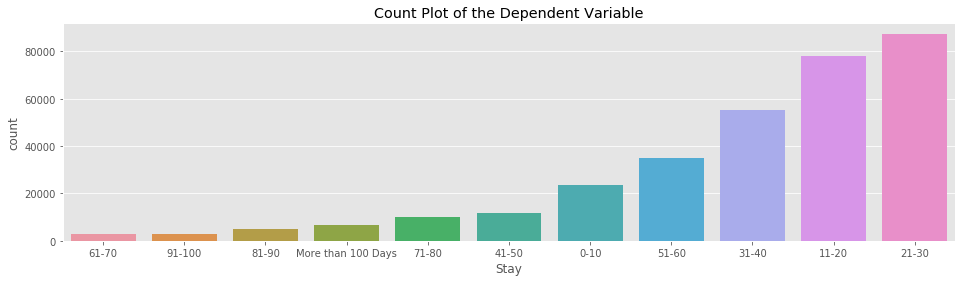

In [14]:
plt.figure(figsize=(16,4));
sns.countplot(x="Stay",data=train, order=train['Stay'].value_counts().sort_values().index);
plt.title("Count Plot of the Dependent Variable");

1.We can see that the highest number of patients are from the Age range 21-30, followed by age ranges 11-20 and 3-40.

2.We can also see that the minimum number of patients are from the Age range 61-70.

3.We can also see that there are good number of patients who stay for more than 100 days.

Independent Variables

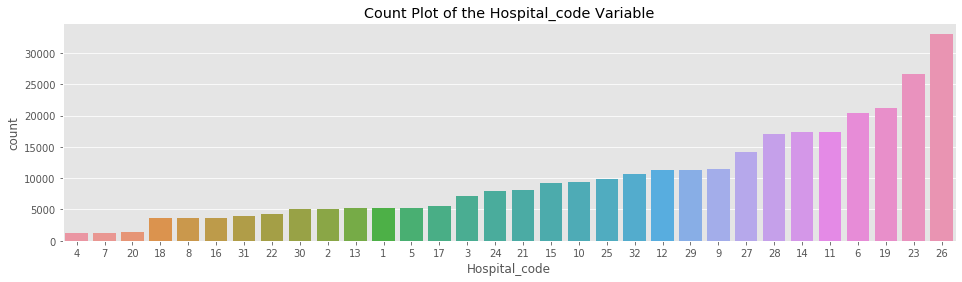

In [15]:
plt.figure(figsize=(16,4));
sns.countplot(x="Hospital_code",data=train, order=train['Hospital_code'].value_counts().sort_values().index);
plt.title("Count Plot of the Hospital_code Variable");

 We can see that almost 10% of the patients are admitted to the hospital with code 26 followed by hospital with code 23.

Hospital codes 4,7 and 20 constitute the least number of patients admitted.

In [16]:
train['Hospital_type'].nunique()

7

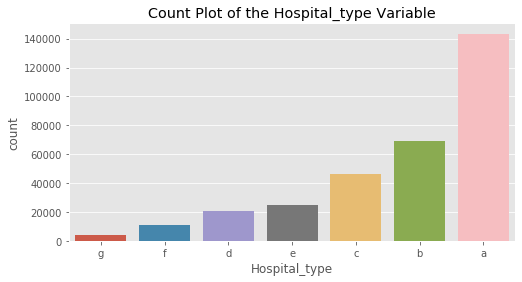

In [17]:
plt.figure(figsize=(8,4));
sns.countplot(x="Hospital_type",data=train, order=train['Hospital_type'].value_counts().sort_values().index);
plt.title("Count Plot of the Hospital_type Variable");

 Hospital_Type a seems to be the most common one with Hospital_Type g being the least common.

In [18]:
train['City_Code_Hospital'].nunique()

11

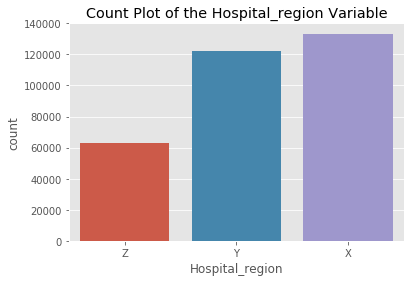

In [21]:

sns.countplot(x="Hospital_region",data=train, order=train['Hospital_region'].value_counts().sort_values().index);
plt.title("Count Plot of the Hospital_region Variable");

# Most of the cases belong to hospitals in region X followed by hospitals in region Y with least numbers from Z region.

In [22]:
train['Extra_Rooms'].value_counts(dropna=False).sort_values()

24        1
14        1
20        2
13        2
21        3
12       13
0        15
11       17
10       67
9       218
8      1027
7      2876
1      5582
6      7786
5     19288
3     91520
4     91709
2     98311
Name: Extra_Rooms, dtype: int64

1.Majority of the hospitals have 2,3, or 4 extra rooms.

2.Some hospitals do not have any extra rooms.

In [24]:
train['Department'].nunique()

5

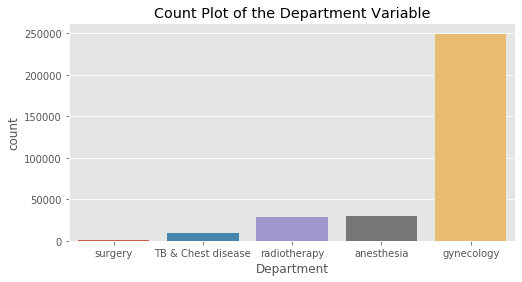

In [25]:

plt.figure(figsize=(8,4));
sns.countplot(x="Department",data=train, order=train['Department'].value_counts().sort_values().index);
plt.title("Count Plot of the Department Variable");


1.Majority of the cases are in Gynecology department followed by Anesthesia and Radiotherapy departments.
2. Surgery has least number of cases.

In [26]:
train['Ward'].nunique()

6

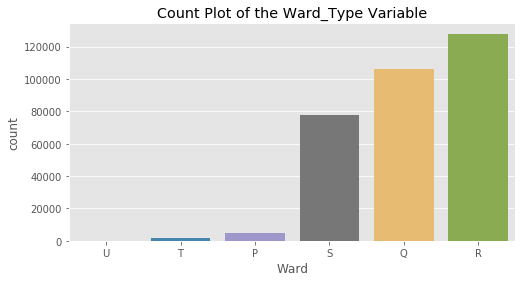

In [27]:
plt.figure(figsize=(8,4));
sns.countplot(x="Ward",data=train, order=train['Ward'].value_counts().sort_values().index);
plt.title("Count Plot of the Ward_Type Variable");

Majority of the cases are in R ward type followed by Q and S. U has the least number of cases.

In [28]:

train['Ward_Facility'].nunique()

6

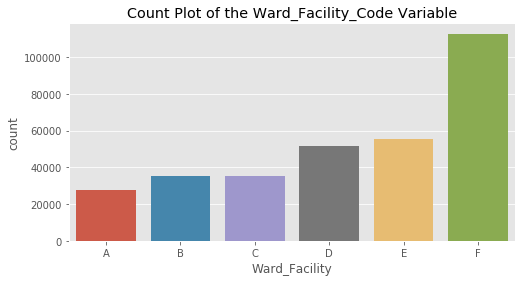

In [29]:
plt.figure(figsize=(8,4));
sns.countplot(x="Ward_Facility",data=train, order=train['Ward_Facility'].value_counts().sort_values().index);
plt.title("Count Plot of the Ward_Facility_Code Variable");

In [30]:
train['Bed_Grade'].nunique()

4

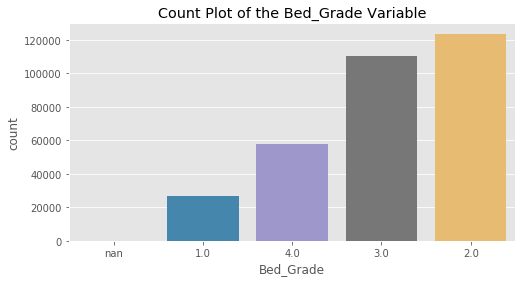

In [31]:
plt.figure(figsize=(8,4));
sns.countplot(x="Bed_Grade",data=train, order=train['Bed_Grade'].value_counts(dropna=False).sort_values().index);
plt.title("Count Plot of the Bed_Grade Variable");

# Most of the cases are admitted to Bed Grade 2 and 3 with least number admitted to Bed Grade 1.
# There are missing values here.

In [32]:
train['City_Code_Patient'].nunique()

37

In [33]:
train['City_Code_Patient'].unique()

array([ 7.,  8.,  2.,  5.,  6.,  3.,  4.,  1.,  9., 14., nan, 25., 15.,
       12., 10., 28., 24., 23., 20., 11., 13., 21., 18., 16., 26., 27.,
       22., 19., 31., 34., 32., 30., 29., 37., 33., 35., 36., 38.])

In [34]:

train['Admission_Type'].nunique()

3

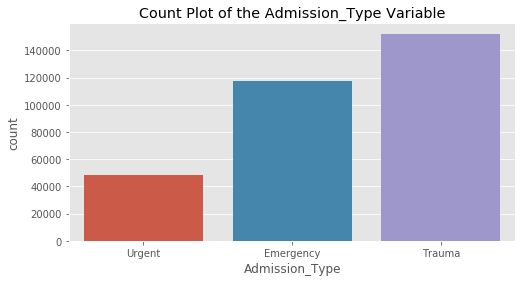

In [35]:
plt.figure(figsize=(8,4));
sns.countplot(x="Admission_Type",data=train, order=train['Admission_Type'].value_counts(dropna=False).sort_values().index);
plt.title("Count Plot of the Admission_Type Variable");

Most of the cases are admitted in the state of Trauma followed by Emergency followed by Urgent admission type

In [37]:
train['Severity'].nunique()

3

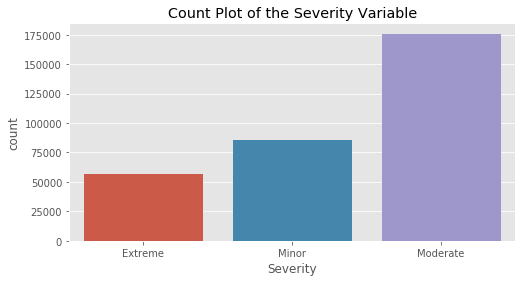

In [38]:

plt.figure(figsize=(8,4));
sns.countplot(x="Severity",data=train, order=train['Severity'].value_counts(dropna=False).sort_values().index);
plt.title("Count Plot of the Severity Variable");

Majority of the people admitted show moderate severity with more than 10% cases showing extreme severity.
There are good proportion of people showing Minor severity.

In [39]:

train['Visitors'].nunique()

28

In [40]:
train['Visitors'].unique()

array([ 2,  4,  3,  8,  6,  7, 13,  5,  1, 10, 15, 11, 12,  9, 24, 16, 14,
       20,  0, 19, 18, 17, 23, 21, 32, 30, 22, 25], dtype=int64)

:
# Visitors accompanying the patient are variety in number as you can see above.
# Most of the patients have 2 visitors accompanying them, some have as high as 32.

In [41]:
train['Visitors'].value_counts(dropna=False).sort_values()

32         9
30         9
23        10
21        11
25        12
19        12
22        19
17        20
0         22
18        61
20        62
24        78
13       106
15       194
14       207
16       286
11       327
12       968
10      1183
1       1207
9       1358
7       2504
8       4872
5       9219
6      18860
3      59180
4      79225
2     138417
Name: Visitors, dtype: int64

In [42]:

train['Age'].nunique()

10

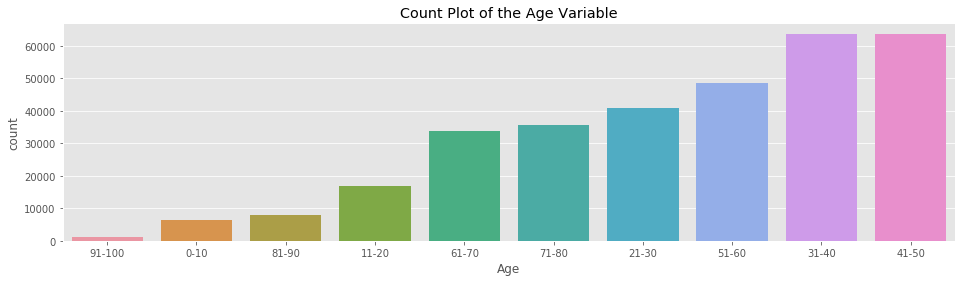

In [43]:

plt.figure(figsize=(16,4));
sns.countplot(x="Age",data=train, order=train['Age'].value_counts().sort_values().index);
plt.title("Count Plot of the Age Variable");


There seems to be almost equal number of patients in the Age Group of 41-50 and 31-40 with majority of them from 41-50 group.
Very few patients in the age group of 91-100, followed by 0-10 group.

In [44]:
train['Deposit'].describe()

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Deposit, dtype: float64

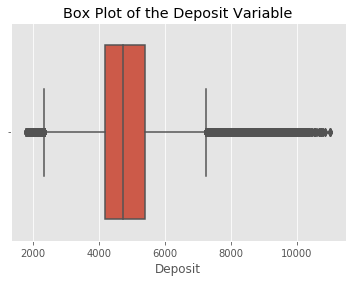

In [45]:
sns.boxplot(train['Deposit']);
plt.title("Box Plot of the Deposit Variable");

In [46]:
IQR = train['Deposit'].quantile(0.75)-train['Deposit'].quantile(0.25)
Upper_Range = train['Deposit'].quantile(0.75)+1.5*IQR
Lower_Range = train['Deposit'].quantile(0.25)-1.5*IQR
print (Upper_Range,Lower_Range)

7243.5 2351.5


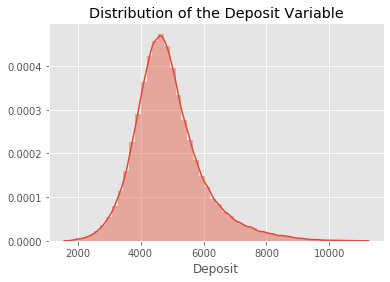

In [47]:

sns.distplot(train['Deposit']);
plt.title("Distribution of the Deposit Variable");

Looks like there are no outliers from the plots above.
The distribution looks almost normal.
The minimum deposit at the time of admission is 1800 and maximum is 11008 with the average amount being 4880.


Bi-Variate Analysis

In [48]:
df = pd.crosstab(index=train['Age'],columns=train['Stay'])
df.style.background_gradient(cmap='Reds')

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Age,,,,,,,,,,,
0-10,615,1959,1489,1014,187,582,26,153,84,35,110
11-20,1552,5343,4312,2681,510,1429,89,350,223,71,208
21-30,3467,11272,11394,6912,1398,3793,263,1026,546,231,541
31-40,4916,15792,18550,10912,2373,6517,509,1807,801,484,978
41-50,4727,14959,17906,10983,2507,7189,562,2146,885,578,1307
51-60,3427,11346,13058,8569,1735,5739,448,1710,784,499,1199
61-70,2194,7870,9033,5930,1205,4081,325,1230,600,330,889
71-80,2201,7958,9534,6420,1383,4433,378,1367,670,386,1062
81-90,422,1392,1920,1504,379,1082,115,402,216,132,326


# Majority of the patients admitted for more than 100 days are from the age group 41-50 closely followed by 51-60 and 71-80.
# Age groups 31-40 and 41-50 form the majority of patients admitted for 31-40 days.
# 31-40 for the majority group in 21-30 days at the hospital.

In [49]:

df = pd.crosstab(index=train['Severity'],columns=train['Stay'])
df.style.background_gradient(cmap='Reds')

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Severity,,,,,,,,,,,
Extreme,3399,10518,15502,10086,2351,7777,647,2575,1113,805,1950
Minor,7866,27081,21535,14447,3000,7128,519,1928,985,425,958
Moderate,12339,40540,50454,30626,6392,20113,1578,5751,2740,1535,3775


We can see that those who are admitted for more than 100 days have moderate severity which is not what we expect.
In almost all the stay brackets, majority of the patients are admitted with Moderate severity.

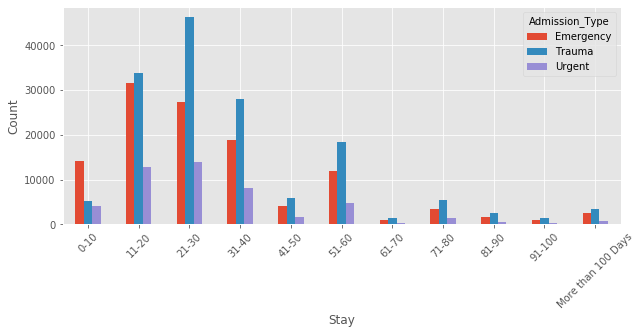

In [50]:

train.groupby("Stay")['Admission_Type'].value_counts().unstack().plot.bar(figsize=(10,4));
plt.ylabel("Count");
plt.xticks(rotation=45);


We can see that those who are admitted for a duration of 21-30 days are mostly Trauma patients.
In the 0-10 bracket, majority of the cases seem to be of Emergency Admission Type.

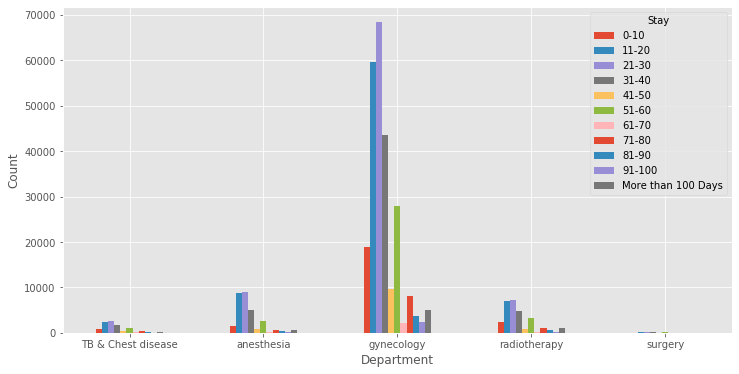

In [51]:
train.groupby("Department")['Stay'].value_counts().unstack().plot.bar(figsize=(12,6));
plt.xticks(rotation=360);
plt.ylabel("Count");

We can see that most of the cases admitted to the Gynecology departments stay for a duration of 21-30 days followed by 11-20 days.
Not much we can see in the Surgery department.

In [52]:
df = pd.crosstab(index=train['Severity'],columns=train['Admission_Type'])
df.style.background_gradient(cmap='Reds')

Admission_Type,Emergency,Trauma,Urgent
Severity,,,
Extreme,19844,28837,8042
Minor,35356,36800,13716
Moderate,62476,86624,26743



We can see that even Minor severity patients are admitted to Emergency ward / Trauma section which is strange.
Also there are patients with Moderate severity being admitted to Emergency / Trauma wards.

In [53]:
df = pd.crosstab(index=train['Age'],columns=train['Department'])
df.style.background_gradient(cmap='Reds')

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Age,,,,,
0-10,387,464,4362,943,98
11-20,694,1315,13021,1694,44
21-30,1237,3320,33437,2771,78
31-40,1563,5030,53296,3626,124
41-50,1717,5608,52212,4031,181
51-60,1858,4875,37798,3779,204
61-70,1308,3860,24460,3864,195
71-80,704,4062,24925,5903,198
81-90,76,913,5236,1598,67


We can see that majority of patients admitted to Gynecology departmentare aged between 30 and 50.
There are very few people admitted to Surgery department.
We can see that majority of patients admitted between ages 0-10 are in Gynecology department (which is kind of strange, may be they are new borns?).

In [54]:

train.groupby("Department")['Deposit'].agg(['count','min','max','mean','median'])
# We can see higher mean deposit amount for TB and Anesthesia departments, although the count is low.
# Mean deposit amount is the least for Gynecology department.

,count,min,max,mean,median
Department,,,,,
TB & Chest disease,9586,1848.0,11008.0,5144.285834,4985.0
anesthesia,29649,1800.0,10999.0,5297.121657,5115.0
gynecology,249486,1801.0,11008.0,4814.569379,4689.0
radiotherapy,28516,1816.0,11008.0,4935.689262,4807.0
surgery,1201,2005.0,10670.0,4941.565362,4749.0


In [55]:

train.groupby("Ward")['Deposit'].agg(['count','min','max','mean','median'])
# we can see the mean deposit amount for all the wards is approximately same , except for Ward U.

,count,min,max,mean,median
Ward,,,,,
P,5046,1801.0,10553.0,4733.466706,4557.5
Q,106165,1802.0,11008.0,4785.998031,4638.0
R,127947,1800.0,11008.0,4942.327643,4810.0
S,77794,1811.0,11008.0,4922.343111,4784.0
T,1477,1934.0,9994.0,4672.391334,4581.0
U,9,3420.0,5171.0,4404.888889,4399.0


In [56]:

train.groupby("Admission_Type")['Deposit'].agg(['count','min','max','mean','median'])
# The mean deposit amount is highest for Trauma admission type.

,count,min,max,mean,median
Admission_Type,,,,,
Emergency,117676,1800.0,10785.0,4768.320609,4649.0
Trauma,152261,1801.0,11008.0,4986.646344,4834.0
Urgent,48501,1809.0,11008.0,4821.084514,4655.0


In [57]:
train.groupby("Severity")['Deposit'].agg(['count','min','max','mean','median'])
# The average deposit amount is highest for Minor severity patients  which is kind of strange.

,count,min,max,mean,median
Severity,,,,,
Extreme,56723,1800.0,11008.0,4747.688627,4614.0
Minor,85872,1810.0,10841.0,4982.241371,4845.0
Moderate,175843,1801.0,11008.0,4874.108733,4728.0


In [58]:
# Generating additional features
hospitals_visited_count_train = train.groupby('patientid')['Hospital_code'].nunique().to_dict()
train['hospitals_visited_by_patient'] = train['patientid'].map(hospitals_visited_count_train)
hospitals_visited_count_test = test.groupby('patientid')['Hospital_code'].nunique().to_dict()
test['hospitals_visited_by_patient'] = test['patientid'].map(hospitals_visited_count_test)


patient_admitted_count_train = train['patientid'].value_counts().to_dict()
train['patient_count'] = train['patientid'].map(patient_admitted_count_train)
patient_admitted_count_test = test['patientid'].value_counts().to_dict()
test['patient_count'] = test['patientid'].map(patient_admitted_count_test)


no_departments_visited_by_a_patient_train = train.groupby('patientid')['Department'].nunique().to_dict()
train['departments_visited'] = train['patientid'].map(no_departments_visited_by_a_patient_train)
no_departments_visited_by_a_patient_test = test.groupby('patientid')['Department'].nunique().to_dict()
test['departments_visited'] = test['patientid'].map(no_departments_visited_by_a_patient_test)


types_of_hospitals_visited_by_a_patient_train = train.groupby('patientid')['Hospital_type'].nunique().to_dict()
train['hospital_types_visited'] = train['patientid'].map(types_of_hospitals_visited_by_a_patient_train)
types_of_hospitals_visited_by_a_patient_test = test.groupby('patientid')['Hospital_type'].nunique().to_dict()
test['hospital_types_visited'] = test['patientid'].map(types_of_hospitals_visited_by_a_patient_test)


hospital_regions_visited_by_a_patient_train = train.groupby('patientid')['Hospital_region'].nunique().to_dict()
train['hospital_regions_visited'] = train['patientid'].map(hospital_regions_visited_by_a_patient_train)
hospital_regions_visited_by_a_patient_test = test.groupby('patientid')['Hospital_region'].nunique().to_dict()
test['hospital_regions_visited'] = test['patientid'].map(hospital_regions_visited_by_a_patient_test)


admission_types_train = train.groupby('patientid')['Admission_Type'].nunique().to_dict()
train['no_of_admission_types'] = train['patientid'].map(admission_types_train)
admission_types_test = test.groupby('patientid')['Admission_Type'].nunique().to_dict()
test['no_of_admission_types'] = test['patientid'].map(admission_types_test)


city_codes_visited_by_a_patient_train = train.groupby('patientid')['City_Code_Hospital'].nunique().to_dict()
train['city_codes_visited'] = train['patientid'].map(city_codes_visited_by_a_patient_train)
city_codes_visited_by_a_patient_test = test.groupby('patientid')['City_Code_Hospital'].nunique().to_dict()
test['city_codes_visited'] = test['patientid'].map(city_codes_visited_by_a_patient_test)


# creating an indicator variable to indicate if there is a change in the department admitted to for a patient
def change_in_department(x):
    if x > 1:
        return True
    else:
        return False
train['Change_In_Department'] = train['departments_visited'].apply(change_in_department)
test['Change_In_Department'] = test['departments_visited'].apply(change_in_department)

In [60]:
agg_func = {
    'Deposit': ['mean','std','sum','median']    
}
agg_func = train.groupby('Hospital_code').agg(agg_func)
agg_func.columns = [ 'Hospital_code_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Hospital_code'], how='left')


agg_func = {
    'Deposit': ['mean','std','sum','median']    
}
agg_func = test.groupby('Hospital_code').agg(agg_func)
agg_func.columns = [ 'Hospital_code_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Hospital_code'], how='left')


unique_patients_by_hospital_code_train = train.groupby('Hospital_code')['patientid'].nunique().to_dict()
train['unique_patients_by_hospital_code'] = train['Hospital_code'].map(unique_patients_by_hospital_code_train)
unique_patients_by_hospital_code_test = test.groupby('Hospital_code')['patientid'].nunique().to_dict()
test['unique_patients_by_hospital_code'] = test['Hospital_code'].map(unique_patients_by_hospital_code_test)

scaler = MinMaxScaler()
for df in [train,test]:
    df[['Visitors']] = scaler.fit_transform(df[['Visitors']])
    df[['unique_patients_by_hospital_code']] = scaler.fit_transform(df[['unique_patients_by_hospital_code']])
    df[['Hospital_code_Deposit_median']] = scaler.fit_transform(df[['Hospital_code_Deposit_median']])
    df[['Hospital_code_Deposit_mean']] = scaler.fit_transform(df[['Hospital_code_Deposit_mean']])
    df[['Hospital_code_Deposit_std']] = scaler.fit_transform(df[['Hospital_code_Deposit_std']])
    df[['Hospital_code_Deposit_sum']] = scaler.fit_transform(df[['Hospital_code_Deposit_sum']])

"""unique_wards_by_hospital_code_train = train.groupby('Hospital_code')['Ward'].nunique().to_dict()
train['unique_wards_by_hospital_code'] = train['Hospital_code'].map(unique_wards_by_hospital_code_train)
unique_wards_by_hospital_code_test = test.groupby('Hospital_code')['Ward'].nunique().to_dict()
test['unique_wards_by_hospital_code'] = test['Hospital_code'].map(unique_wards_by_hospital_code_test)"""

"unique_wards_by_hospital_code_train = train.groupby('Hospital_code')['Ward'].nunique().to_dict()\ntrain['unique_wards_by_hospital_code'] = train['Hospital_code'].map(unique_wards_by_hospital_code_train)\nunique_wards_by_hospital_code_test = test.groupby('Hospital_code')['Ward'].nunique().to_dict()\ntest['unique_wards_by_hospital_code'] = test['Hospital_code'].map(unique_wards_by_hospital_code_test)"

In [61]:

# creating interaction features
for df in [train,test]:
    df['Dep_Adm'] = df['Department']+"_"+df['Admission_Type']
    df['Dep_Sev'] = df['Department']+"_"+df['Severity']
    df['Adm_Sev'] = df['Admission_Type']+"_"+df['Severity']

In [62]:
for df in [train,test]:
    df['Bed_Grade'].fillna(df['Bed_Grade'].value_counts().index[0],inplace=True)
    df['Bed_Grade'] = df['Bed_Grade'].astype("uint8")
    df['City_Code_Patient'].fillna(df['City_Code_Patient'].value_counts().index[0],inplace=True)
    df['City_Code_Patient'] = df['City_Code_Patient'].astype("uint8")
    
    # dropping the patientid variable
    df.drop("patientid",axis=1,inplace=True)
    
    # normalizing the deposit amount feature
    df['Deposit'] = np.log1p(df['Deposit'])
    df['Deposit'] = df['Deposit'].astype("float16")

In [63]:

# Replacing the categories in the target variable.
train['Stay'].replace({"0-10":1,"11-20":2,"21-30":3,"31-40":4,"41-50":5,"51-60":6,"61-70":7,"71-80":8,"81-90":9,"91-100":10,"More than 100 Days":11},inplace=True)
train['Stay'] = train['Stay'].astype('uint8')

In [64]:

# label encoding the numerical variables that are categorical in nature.
le = LabelEncoder()
cat_cols = ['Hospital_code','Hospital_type','City_Code_Hospital','Hospital_region','Extra_Rooms','Department','Ward',
            'Ward_Facility','Bed_Grade','City_Code_Patient','Admission_Type','Severity','Age','Dep_Adm','Dep_Sev','Adm_Sev']
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

In [65]:
train.head()

,Hospital_code,Hospital_type,City_Code_Hospital,Hospital_region,Extra_Rooms,Department,Ward,Ward_Facility,Bed_Grade,City_Code_Patient,Admission_Type,Severity,Visitors,Age,Deposit,Stay,hospitals_visited_by_patient,patient_count,departments_visited,hospital_types_visited,hospital_regions_visited,no_of_admission_types,city_codes_visited,Change_In_Department,Hospital_code_Deposit_mean,Hospital_code_Deposit_std,Hospital_code_Deposit_sum,Hospital_code_Deposit_median,unique_patients_by_hospital_code,Dep_Adm,Dep_Sev,Adm_Sev
0,7,2,2,2,3,3,2,5,1,6,0,0,0.0625,5,8.500000,1,10,14,3,7,3,3,7,True,0.395032,0.203087,0.072530,0.426070,0.096110,9,9,0
1,1,2,4,2,2,3,3,5,1,6,1,0,0.0625,5,8.695312,5,10,14,3,7,3,3,7,True,0.454953,0.400267,0.120476,0.417315,0.126614,10,9,3
2,9,4,0,0,2,1,3,4,1,6,1,0,0.0625,5,8.468750,4,10,14,3,7,3,3,7,True,0.056855,0.207194,0.233082,0.056420,0.314760,4,3,3
3,25,1,1,1,2,3,2,3,1,6,1,0,0.0625,5,8.890625,5,10,14,3,7,3,3,7,True,0.363093,0.507587,1.000000,0.340953,1.000000,10,9,3
4,25,1,1,1,2,3,3,3,1,6,1,0,0.0625,5,8.625000,5,10,14,3,7,3,3,7,True,0.363093,0.507587,1.000000,0.340953,1.000000,10,9,3


In [66]:
"""# Creating dummy variables out of the object variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print ("Train Shape:",train.shape)
print ("Test Shape:",test.shape)"""

'# Creating dummy variables out of the object variables\ntrain = pd.get_dummies(train)\ntest = pd.get_dummies(test)\nprint ("Train Shape:",train.shape)\nprint ("Test Shape:",test.shape)'

In [67]:
# separating the dependent and independent variables. 
X = train[[col for col in train.columns if col!="Stay"]]
y = train['Stay']

In [68]:
X.shape

(318438, 31)

In [69]:
accuracy = []
final_preds = []
folds = StratifiedKFold(n_splits=5)
for train_index, test_index in folds.split(X,y):
    # creating training and validation datasets
    X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
    y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]
    
    # building a classifier
    clf = lgb.LGBMClassifier(n_estimators=750,
                             learning_rate=0.1,
                             objective="multiclass",
                             boosting_type="gbdt",
                             subsample=0.9,
                             colsample_bytree=0.6,
                             num_class=11,
                             max_depth=12,
                             n_jobs=-1,
                             reg_alpha=2,
                             num_leaves=100)
    
    # fitting the classifier to the train set
    clf.fit(X_Train,
            y_Train,
            eval_set=[(X_Train,y_Train),(X_Test,y_Test)],
            early_stopping_rounds=50,
            verbose=50,
            categorical_feature = cat_cols)
    
    # predicting on the validation set
    preds = clf.predict(X_Test)
    score = accuracy_score(preds,y_Test)
    print ("Accuracy Score:",score)
    print ("------------------------------------------------")
    accuracy.append(score)
    
    # Predicting on the test set, final_preds will be an array of 5 sets of predictions, one for each fold
    pred = clf.predict(test,num_iteration=None)
    final_preds.append(pred)
    
print ("------------------------------------------")
print ("Mean Accuracy of 5 Folds:",np.mean(np.array(accuracy)))

C:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Adm_Sev', 'Admission_Type', 'Age', 'Bed_Grade', 'City_Code_Hospital', 'City_Code_Patient', 'Dep_Adm', 'Dep_Sev', 'Department', 'Extra_Rooms', 'Hospital_code', 'Hospital_region', 'Hospital_type', 'Severity', 'Ward', 'Ward_Facility']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridde

Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 1.38059	valid_1's multi_logloss: 1.48319
[100]	training's multi_logloss: 1.28355	valid_1's multi_logloss: 1.47728
Early stopping, best iteration is:
[86]	training's multi_logloss: 1.3064	valid_1's multi_logloss: 1.47682
Accuracy Score: 0.43373947996482853
------------------------------------------------
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 1.37612	valid_1's multi_logloss: 1.49728
[100]	training's multi_logloss: 1.27882	valid_1's multi_logloss: 1.49318
Early stopping, best iteration is:
[80]	training's multi_logloss: 1.31201	valid_1's multi_logloss: 1.49217
Accuracy Score: 0.428432357744002
------------------------------------------------
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 1.3767	valid_1's multi_logloss: 1.49838
[100]	training's multi_logloss: 1.27936	valid_1's multi_logloss: 1.49433
Ea

In [70]:
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser

Change_In_Department                  169
Department                            196
Ward_Facility                         247
Hospital_region                       315
Hospital_type                         374
Admission_Type                        926
departments_visited                  1005
hospital_regions_visited             1049
no_of_admission_types                1111
Severity                             1121
unique_patients_by_hospital_code     1241
Hospital_code_Deposit_median         1320
Bed_Grade                            1600
City_Code_Hospital                   1731
Ward                                 1745
hospital_types_visited               2030
Hospital_code_Deposit_mean           2072
Hospital_code_Deposit_std            2128
Hospital_code_Deposit_sum            2197
Extra_Rooms                          2410
city_codes_visited                   2723
Adm_Sev                              3025
Dep_Adm                              3145
Dep_Sev                           

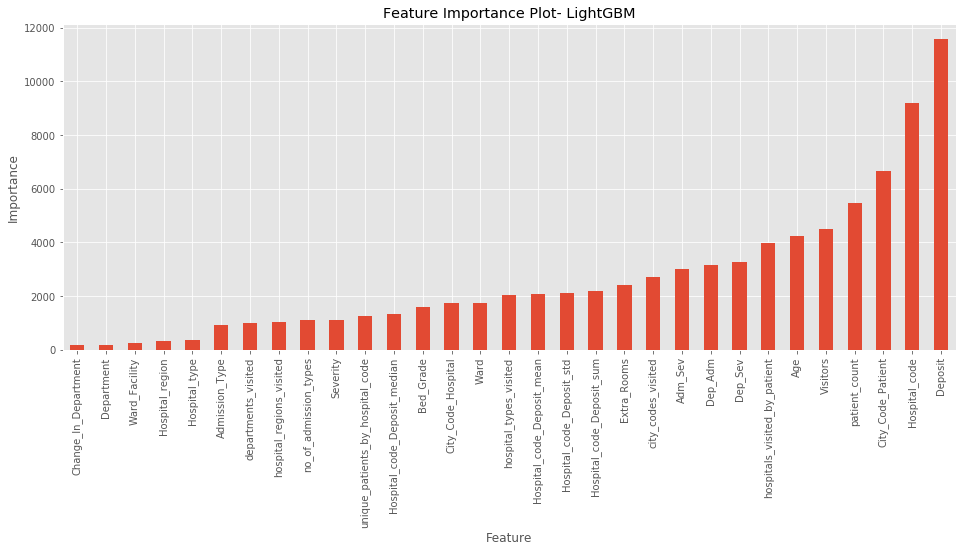

In [71]:
# plotting Feature Importance
plt.figure(figsize=(16,6));
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser.plot(kind='bar');
plt.title("Feature Importance Plot- LightGBM");
plt.xlabel("Feature");
plt.ylabel("Importance");

In [72]:
# Each set of prediction is converted to a column in the dataframe and a mode of each observation across the columns is found.
Submission['Stay_1'] = final_preds[0]
Submission['Stay_2'] = final_preds[1]
Submission['Stay_3'] = final_preds[2]
Submission['Stay_4'] = final_preds[3]
Submission['Stay_5'] = final_preds[4]

stays = ['Stay_{}'.format(i) for i in range(1, 6)]
ser = Submission[stays].mode(axis=1, dropna=False)[0]

Submission['Stay'] = ser
Submission.drop(['Stay_1','Stay_2','Stay_3','Stay_4','Stay_5'],axis=1,inplace=True)

Submission['Stay'].replace({1:"0-10",2:"11-20",3:"21-30",4:"31-40",5:"41-50",6:"51-60",7:"61-70",8:"71-80",9:"81-90",10:"91-100",11:"More than 100 Days"},inplace=True)
Submission.to_csv("Solution_30.csv",index=None)

In [ ]:
# Checking the distribution in the prediction.
Submission['Stay'].value_counts()